In [1]:
import pandas as pd
import numpy as np
import datetime
import pickle
import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dropout, BatchNormalization, Activation
from keras.models import Model
import tensorflow
import matplotlib.pyplot as plt
from keras.models import load_model

2023-03-10 15:59:51.806607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 15:59:54.135772: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hpc/mp/spack/opt/spack/linux-ubuntu20.04-zen2/gcc-10.3.0/cudnn-8.2.4.15-11.4-eluwegpwn6adr7hlku5p5wru5xzefpop/lib64:/hpc/mp/spack/opt/spack/linux-ubuntu20.04-zen2/gcc-10.3.0/cuda-11.4.4-ctldo35wmmwws3jbgwkgjjcjawddu3qz/lib64:/hpc/mp/spack/opt/spack/linux-ubuntu20.04-zen2/gcc-10.3.0/neovim-0.7.0-terkir3wk5rst6ktv4uxyaqjditacv5p/lib
2023-03-10 15:59:54.135915: W tensorflow/compiler/xla/stream_execut

In [2]:
# make tensorlfow work better with gpus:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

# eager execution:
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

# Overview of Dataset

What is the classification task and what is the format of the feature data. Is this multi-task, multi-modal, or both? Explain.
Who collected the data? Why? When?
What evaluation criteria will you be using and why? 

https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/

We are using the IMDB-Wiki dataset for multi-task learning of Age and Gender from facial image data. We will be doing multi-task by training a model to classify geneder and regress age of a certain person based on their picture. The images in this dataset are preprocessed so that they are cropped to the persons face.


This dataset was collected by Rasmus Rothe, Radu Timofte and Luc Van Gool. This data was collecteted by crawling through Wikipedia celebrity profile pages and extracting their Age and Gender as well as their profile image. The images that did not have a timestamp were removed. The data was extracted to provide a dataset for age prediction.


We will be evaluating our gender prediction task with Accuracy and AUC score. We will evaluate the age regression model with mean absolute error. 


# Tasks

This dataset has two target tasks, predicting the age and gender of a person given their image. Both tasks are within the same domain of identifying features of a person based on their image.

In [3]:
# CONSTANTS

DATA_DIR = "/work/users/skoka/Data/wiki_crop/"
META_DATA =  "/work/users/skoka/Data/wiki_crop/wiki.mat"

PICKLES_PATH = "/work/users/skoka/Data/wiki_crop_pickles/"
GET_IMAGES_FROM_PICKLE = True

In [4]:
# extract data from a .mat file
import scipy.io as sio


mat = sio.loadmat(META_DATA)
# convert the data to a pandas dataframe
mat_data = mat['wiki'][0][0]

# 0 -> Matlab datatime format
# 1 -> Years
# 2 -> Path to image
# 3 -> Gender

# convert Matlab serial date number to datetime object
def matlab_to_datetime(matlab_serial_date):
    python_datetime = datetime.datetime.fromordinal(int(matlab_serial_date)) + \
                      datetime.timedelta(days=matlab_serial_date % 1) - \
                      datetime.timedelta(days=366)
    return python_datetime

def get_age(born_matlab_date, current_year):
    return current_year - matlab_to_datetime(born_matlab_date).year

new_data = [
    # {
        # image_path, gender, age
    # }
]

for i in range(len(mat_data[0][0])):
    new_data.append({
        "image_path": mat_data[2][0][i][0],
        "age": get_age(int(mat_data[0][0][i]), mat_data[1][0][i]),
        "gender": mat_data[3][0][i]
    })

df = pd.DataFrame(new_data)

In [5]:
# reading in images:
from PIL import Image
import os

def read_image(path):
    image = Image.open(os.path.join(DATA_DIR, path))
    image = image.resize((256, 256))
    return np.array(image)

if not GET_IMAGES_FROM_PICKLE:
    list_of_images = []
    for i in range(len(df)):
        list_of_images.append(read_image(df["image_path"][i]))
    with open(PICKLES_PATH + "list_of_images.pickle", "wb") as f:
        pickle.dump(list_of_images, f)
else:
    with open(PICKLES_PATH + "list_of_images.pickle", "rb") as f:
        list_of_images = pickle.load(f)

In [6]:
# making every image 3 channels if it isnt already
for i in range(len(list_of_images)):
    if len(list_of_images[i].shape) != 3:
        list_of_images[i] = np.stack((list_of_images[i],) * 3, axis=-1)

# adding the images to the dataframe
df["image"] = list_of_images
# drop na from the dataframe
df = df.dropna()

In [7]:
# remove images that have a mean value of 0, blank images
df = df[df["image"].apply(lambda x: x.mean()) != 0]
# get rid of images that have a mean of the most common mean, to get rid of placeholder images that are meaningless
mean = df["image"].apply(lambda x: x.mean()).value_counts().index[0]
df = df[df["image"].apply(lambda x: x.mean()) != mean]

# get rid of ages over 110 becuase these are most likely errors
df = df[df["age"] < 110]
# get rid of ages < 0
df = df[df["age"] > 0]

In [8]:
# Shuffleing the Dataset becuase it is currently ordered by person's date of birth
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = np.array(df["image"])
X = np.concatenate(X)
X = X.reshape(-1, 256, 256, 3)
X = X / 255.0 # normalizing the data
Y_age = df["age"].values.astype('float32')
Y_gender = df["gender"].values.astype('float32')

Text(0, 0.5, 'Count')

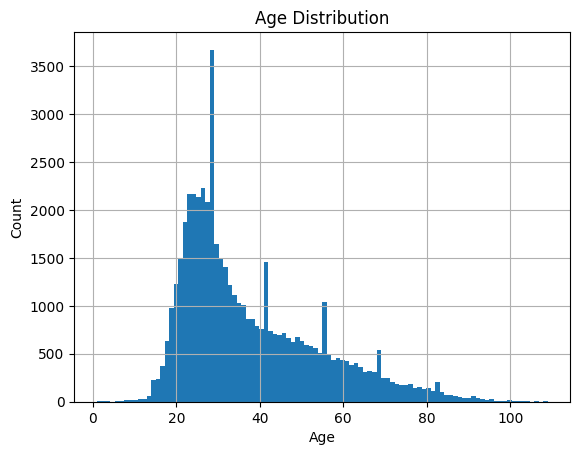

In [9]:
df["age"].hist(bins=100)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")

This plot shows the age distribution after filtering error values. Even now the data shows some suspicious spikes but it is difficult to remove those potential errors due to the volume of those values.

In [10]:
df["gender"].value_counts()

1.0    39842
0.0    12067
Name: gender, dtype: int64

Here, the label 1 refers to males and the 0 refers to females. As we can see we have a class imbalance problem.

In [11]:
# sklearn train test split:
from sklearn.model_selection import train_test_split

# same random states so that the same images are in the same sets
X_train, X_test, Y_age_train, Y_age_test = train_test_split(X, Y_age, test_size=0.2, random_state=42, stratify=Y_gender)
_, _, Y_gender_train, Y_gender_test = train_test_split(X, Y_gender, test_size=0.2, random_state=42, stratify=Y_gender)

## Train Test Split:

For this model, we need to have the same feature data for training across both tasks, becuase if we don't it would result in validation data leaking into the model. Because of the significant class imbalance we will stratify the data across gender. We decided to do an 80/20 split because we feel we have sufficient data with over 50,000 images after filtering. We didn't observe this egregious of am imbalance with age after filtering.

In [12]:
# Save X_train, X_test, Y_age_train, Y_age_test, Y_gender_train, Y_gender_test to pickle files
with open(PICKLES_PATH + "X_train.pickle", "wb") as f:
    pickle.dump(X_train, f)
with open(PICKLES_PATH + "X_test.pickle", "wb") as f:
    pickle.dump(X_test, f)
with open(PICKLES_PATH + "Y_age_train.pickle", "wb") as f:
    pickle.dump(Y_age_train, f)
with open(PICKLES_PATH + "Y_age_test.pickle", "wb") as f:
    pickle.dump(Y_age_test, f)
with open(PICKLES_PATH + "Y_gender_train.pickle", "wb") as f:
    pickle.dump(Y_gender_train, f)
with open(PICKLES_PATH + "Y_gender_test.pickle", "wb") as f:
    pickle.dump(Y_gender_test, f)

In [4]:
# load all the pickle files from above into variables:

with open(PICKLES_PATH + "X_train.pickle", "rb") as f:
    X_train = pickle.load(f)
with open(PICKLES_PATH + "X_test.pickle", "rb") as f:
    X_test = pickle.load(f)
with open(PICKLES_PATH + "Y_age_train.pickle", "rb") as f:
    Y_age_train = pickle.load(f)
with open(PICKLES_PATH + "Y_age_test.pickle", "rb") as f:
    Y_age_test = pickle.load(f)
with open(PICKLES_PATH + "Y_gender_train.pickle", "rb") as f:
    Y_gender_train = pickle.load(f)
with open(PICKLES_PATH + "Y_gender_test.pickle", "rb") as f:
    Y_gender_test = pickle.load(f)

# Seperate Models

## Gender Classification:

In [18]:
# code taken from our lab 6 from 7324
def resnet_block(input, output_filters, strides=1):
    input_filters = input.shape[-1]
    if input_filters != output_filters:
        new_add = tf.keras.layers.Conv2D(output_filters, (1, 1), activation='relu', strides=strides, kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.Conv2D(output_filters, (3,3), padding="same", strides=strides, kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(output_filters, (3,3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if input_filters != output_filters:
        x = tf.keras.layers.Add()([x, new_add])
    else:
        x = tf.keras.layers.Add()([x, input])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:

strategy = tf.distribute.MirroredStrategy(
    devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3", "/gpu:4", "/gpu:5", "/gpu:6", "/gpu:7"]
)
with strategy.scope():
    input = tf.keras.Input(shape=(256, 256, 3))

    x = tf.keras.layers.Conv2D(16, (7, 7), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.BatchNormalization()(x)

    # resnet block - note that all of our models will have an identical resnet to process the images
    x = resnet_block(x, 16)
    x = resnet_block(x, 16)
    x = resnet_block(x, 32, 2)
    x = resnet_block(x, 32)
    x = resnet_block(x, 64, 2)
    x = resnet_block(x, 64)

    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    dense = tf.keras.layers.Flatten()(x)
    dense = tf.keras.layers.Dropout(0.3)(dense)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    gender_classification_model = tf.keras.Model(inputs=input, outputs=output)

    gender_classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    gender_classification_model.summary()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

2023-03-08 23:15:00.820354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 23:15:05.142545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-03-08 23:15:05.148225: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79117 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-03-08 23:15:05.153874: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/devi

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 250, 250, 16  2368        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 250, 250, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:

history = gender_classification_model.fit(X_train,
        Y_gender_train,
        epochs=25,
        batch_size=64,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)],
        validation_data=(X_test, Y_gender_test))
gender_classification_model.save(PICKLES_PATH + "gender_classification_model.h5")

Epoch 1/25
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1


2023-03-08 23:16:10.684593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 23:16:11.748277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 23:16:12.997964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 23:16:14.528513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 23:16:16.749655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-08 23:16:20.101130: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7efc04693e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-08 23:16:20.101163: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0

649/649 [==============================] - 88s 86ms/step - loss: 1.2822 - accuracy: 0.7592 - val_loss: 0.7771 - val_accuracy: 0.8070
Epoch 2/25
649/649 [==============================] - 43s 66ms/step - loss: 0.6892 - accuracy: 0.8123 - val_loss: 0.5730 - val_accuracy: 0.8453
Epoch 3/25
649/649 [==============================] - 47s 73ms/step - loss: 0.5273 - accuracy: 0.8407 - val_loss: 0.4824 - val_accuracy: 0.8502
Epoch 4/25
649/649 [==============================] - 43s 67ms/step - loss: 0.4549 - accuracy: 0.8574 - val_loss: 0.4754 - val_accuracy: 0.8401
Epoch 5/25
649/649 [==============================] - 49s 76ms/step - loss: 0.4267 - accuracy: 0.8631 - val_loss: 0.5759 - val_accuracy: 0.7987
Epoch 6/25
649/649 [==============================] - 49s 75ms/step - loss: 0.3895 - accuracy: 0.8721 - val_loss: 0.4857 - val_accuracy: 0.8228
Epoch 7/25
649/649 [==============================] - 47s 73ms/step - loss: 0.4022 - accuracy: 0.8724 - val_loss: 0.4307 - val_accuracy: 0.8538
Epo

Text(0.5, 1.0, 'Loss over epochs')

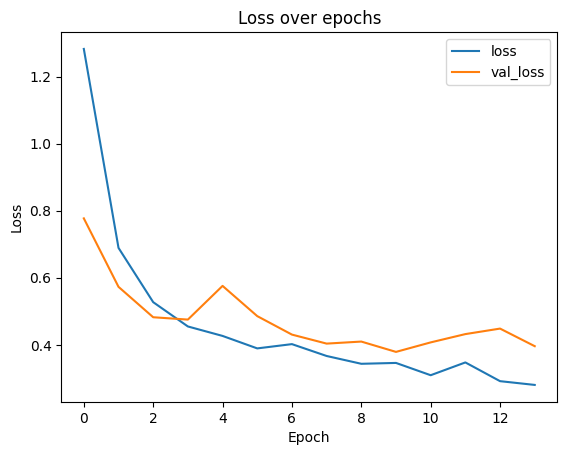

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss over epochs")

The validation loss converges in about 9 epochs. We define convergence as no improvment over 4 epochs.

In [5]:
gender_classification_model = load_model(PICKLES_PATH + "gender_classification_model.h5")

2023-03-10 15:26:01.319089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 15:26:02.254082: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:bd:00.0, compute capability: 8.0


In [7]:
y_hat_gender_classification_model = gender_classification_model.predict(X_test)
# save to pickle:

with open(PICKLES_PATH + "y_hat_gender_classification_model.pkl", "wb") as f:
    pickle.dump(y_hat_gender_classification_model, f)

325/325 [==============================] - 7s 20ms/step


## Age Regression Model:

In [ ]:
strategy = tf.distribute.MirroredStrategy(
    devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3", "/gpu:4", "/gpu:5", "/gpu:6", "/gpu:7"]
)
with strategy.scope():

    input = tf.keras.Input(shape=(256, 256, 3))

    x = tf.keras.layers.Conv2D(16, (7, 7), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.BatchNormalization()(x)

    # resnet block
    x = resnet_block(x, 16)
    x = resnet_block(x, 16)
    x = resnet_block(x, 32, 2)
    x = resnet_block(x, 32)
    x = resnet_block(x, 64, 2)
    x = resnet_block(x, 64)

    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    dense = tf.keras.layers.Flatten()(x)
    dense = tf.keras.layers.Dropout(0.3)(dense)
    output = tf.keras.layers.Dense(1, activation='linear')(dense)

    age_regression_model = tf.keras.Model(inputs=input, outputs=output)

    age_regression_model.compile(optimizer='adam', loss='mse')

    age_regression_model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INF

2023-03-08 22:58:13.236120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 22:58:17.391490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-03-08 22:58:17.395399: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79117 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-03-08 22:58:17.399014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/devi

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                             

In [ ]:
history = age_regression_model.fit(X_train,
        Y_age_train,
        epochs=25,
        batch_size=64,
        validation_data=(X_test, Y_age_test),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)])
age_regression_model.save(PICKLES_PATH + "age_regression_model.h5")

Epoch 1/25
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1


2023-03-08 22:59:38.957140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:59:39.997172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:59:41.226403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:59:42.892046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:59:44.341097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:59:45.728364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:59:47.125111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:59:48.332212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:59:50.389206: I tensorflow/compiler/xla/st

649/649 [==============================] - 104s 71ms/step - loss: 241.1260 - val_loss: 460.7217
Epoch 2/25
649/649 [==============================] - 29s 45ms/step - loss: 189.2840 - val_loss: 332.9865
Epoch 3/25
649/649 [==============================] - 29s 45ms/step - loss: 169.0851 - val_loss: 179.4767
Epoch 4/25
649/649 [==============================] - 29s 44ms/step - loss: 156.1411 - val_loss: 191.0158
Epoch 5/25
649/649 [==============================] - 30s 45ms/step - loss: 148.0820 - val_loss: 153.7239
Epoch 6/25
649/649 [==============================] - 31s 47ms/step - loss: 137.8512 - val_loss: 188.7496
Epoch 7/25
649/649 [==============================] - 33s 51ms/step - loss: 131.5545 - val_loss: 170.7551
Epoch 8/25
649/649 [==============================] - 31s 47ms/step - loss: 124.6967 - val_loss: 150.6117
Epoch 9/25
649/649 [==============================] - 34s 52ms/step - loss: 118.3035 - val_loss: 167.5344
Epoch 10/25
649/649 [==============================] - 3

Text(0.5, 1.0, 'Loss over epochs')

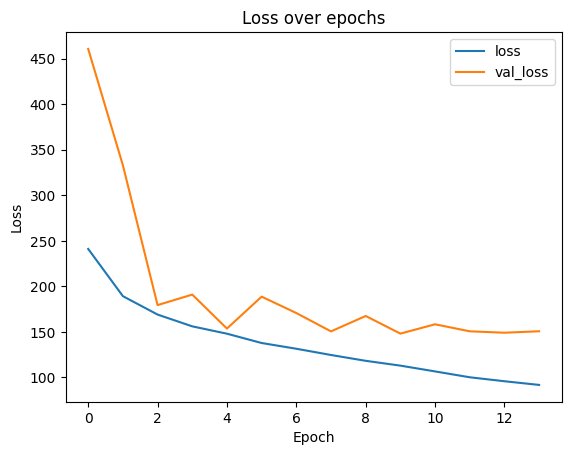

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss over epochs")

The validation loss converges in about 12 epochs. We define convergence as no improvment over 4 epochs.

In [8]:
age_regression_model = load_model(PICKLES_PATH + "age_regression_model.h5")
y_hat_age_regression_model = age_regression_model.predict(X_test)
# save to pickle:

with open(PICKLES_PATH + "y_hat_age_regression_model.pkl", "wb") as f:
    pickle.dump(y_hat_age_regression_model, f)

325/325 [==============================] - 7s 17ms/step


## Multi Task Model:

In [ ]:
strategy = tf.distribute.MirroredStrategy(
    devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3", "/gpu:4", "/gpu:5", "/gpu:6", "/gpu:7"]
)

with strategy.scope():

    input = tf.keras.Input(shape=(256, 256, 3))

    x = tf.keras.layers.Conv2D(16, (7, 7), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.BatchNormalization()(x)

    # resnet block
    x = resnet_block(x, 16)
    x = resnet_block(x, 16)
    x = resnet_block(x, 32, 2)
    x = resnet_block(x, 32)
    x = resnet_block(x, 64, 2)
    x = resnet_block(x, 64)

    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    dense = tf.keras.layers.Flatten()(x)
    # more dropout
    dense = tf.keras.layers.Dropout(0.5)(dense)

    age_dense = tf.keras.layers.Dense(1, activation='linear')(dense)
    gender_dense = tf.keras.layers.Dense(1, activation='sigmoid', )(dense)

    multi_task_model = Model(inputs=[input], outputs=[age_dense, gender_dense])

    multi_task_model.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], loss_weights=[0.003, 0.997]) # we estimated these weights by running the model a few times and looking at the proportion between the ending validation losses

    multi_task_model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-03-08 22:46:23.876370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 22:46:28.029394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-03-08 22:46:28.033229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79117 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-03-08 22:46:28.036820: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/devi

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
history = multi_task_model.fit(X_train,
        [Y_age_train, Y_gender_train],
        epochs=25,
        validation_data=(X_test, [Y_age_test, Y_gender_test]),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)],
        batch_size=64)
multi_task_model.save(PICKLES_PATH + "multi_task_model.h5")

Epoch 1/25
INFO:tensorflow:batch_all_reduce: 60 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 60 all-reduces with algorithm = nccl, num_packs = 1


2023-03-08 22:47:56.970162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:47:58.081353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:47:59.326546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:48:00.947826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:48:02.363153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:48:03.785330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:48:05.218432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:48:06.628340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:48:09.597975: I tensorflow/compiler/xla/st

649/649 [==============================] - 117s 83ms/step - loss: 1.8198 - dense_loss: 284.9066 - dense_1_loss: 0.8444 - val_loss: 1.2001 - val_dense_loss: 229.0342 - val_dense_1_loss: 0.4248
Epoch 2/25
649/649 [==============================] - 35s 54ms/step - loss: 1.1775 - dense_loss: 215.8962 - dense_1_loss: 0.4928 - val_loss: 1.0403 - val_dense_loss: 211.2932 - val_dense_1_loss: 0.4187
Epoch 3/25
649/649 [==============================] - 33s 50ms/step - loss: 0.9492 - dense_loss: 194.1459 - dense_1_loss: 0.3983 - val_loss: 0.8725 - val_dense_loss: 194.6790 - val_dense_1_loss: 0.3496
Epoch 4/25
649/649 [==============================] - 33s 51ms/step - loss: 0.8516 - dense_loss: 184.5024 - dense_1_loss: 0.3666 - val_loss: 0.8945 - val_dense_loss: 193.6483 - val_dense_1_loss: 0.4047
Epoch 5/25
649/649 [==============================] - 34s 53ms/step - loss: 0.7999 - dense_loss: 178.0267 - dense_1_loss: 0.3492 - val_loss: 0.7875 - val_dense_loss: 185.0467 - val_dense_1_loss: 0.3291


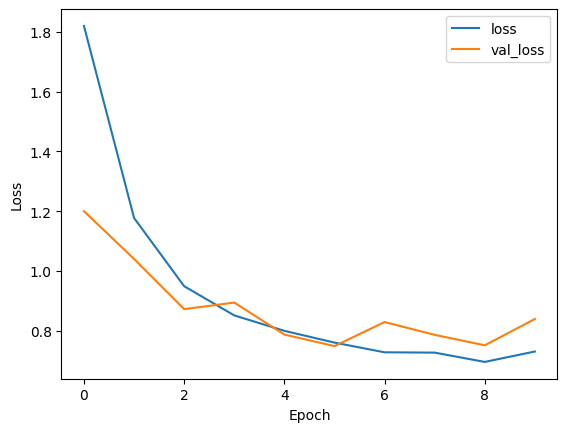

In [ ]:
# plot history:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

The validation loss converges in about 8 epochs. We define convergence as no improvment over 4 epochs.

In [9]:
multi_task_model = load_model(PICKLES_PATH + "multi_task_model.h5")
y_hat_multi_task_model = multi_task_model.predict(X_test)

# save to pickle:
with open(PICKLES_PATH + "y_hat_multi_task_model.pkl", "wb") as f:
    pickle.dump(y_hat_multi_task_model, f)

325/325 [==============================] - 6s 18ms/step


## Semi-Supervised MultiTask (With AutoEncoder for image reconstruction as Auxilary task)

For the extra analysis, we will try to perform self supervised learning by using the auxllary task of image recnstruction and train an autoencoder with essentially the same architecture for the encoders as before, and train it to convergence. Then wwe will attempt to use just the learned encoder weights and try to train a multitask model starting from these weights. 

In [13]:
strategy = tf.distribute.MirroredStrategy(
    devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3", "/gpu:4", "/gpu:5", "/gpu:6", "/gpu:7"]
)

with strategy.scope():

    input = tf.keras.Input(shape=(256, 256, 3))

    x = tf.keras.layers.Conv2D(16, (7, 7), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), padding="same")(input) # difference from previous model - padding
    x = tf.keras.layers.BatchNormalization()(x)

    # resnet block
    x = resnet_block(x, 16)
    x = resnet_block(x, 16)
    x = resnet_block(x, 32, 2)
    x = resnet_block(x, 32)
    x = resnet_block(x, 64, 2)
    x = resnet_block(x, 64)
    x = tf.keras.layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same')(x)
    x_add = Conv2D(32, (1, 1), activation='relu', padding="same")(x)
    x = tf.keras.layers.Add()([x, x_add])
    x = tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same')(x)
    x_add = Conv2D(16, (1, 1), activation='relu', padding="same")(x)
    x = tf.keras.layers.Add()([x, x_add])
    output = Conv2D(3, (7, 7), activation='sigmoid', padding="same")(x)
    auto_encoder = Model(inputs=[input], outputs=[output])

    auto_encoder.compile(optimizer='adam', loss='mse')
    

    auto_encoder.summary()

    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INF

2023-03-10 10:54:56.909841: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 10:55:01.015021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-03-10 10:55:01.018835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79117 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-03-10 10:55:01.027172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/devi

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                             

In [14]:
history = auto_encoder.fit(X_train, X_train, epochs=25, batch_size=16, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)])
auto_encoder.save(PICKLES_PATH + "auto_encoder.h5")

Epoch 1/25
INFO:tensorflow:batch_all_reduce: 66 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 66 all-reduces with algorithm = nccl, num_packs = 1


2023-03-10 10:57:22.187679: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-10 10:57:23.315271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-10 10:57:24.543267: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-10 10:57:26.206838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-10 10:57:27.623883: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-10 10:57:28.912325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-10 10:57:30.390786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-10 10:57:31.621136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-10 10:57:42.868179: I tensorflow/compiler/xla/se

2596/2596 [==============================] - 135s 28ms/step - loss: 0.0225
Epoch 2/25
2596/2596 [==============================] - 65s 25ms/step - loss: 0.0072
Epoch 3/25
2596/2596 [==============================] - 64s 25ms/step - loss: 0.0059
Epoch 4/25
2596/2596 [==============================] - 64s 24ms/step - loss: 0.0052
Epoch 5/25
2596/2596 [==============================] - 63s 24ms/step - loss: 0.0050
Epoch 6/25
2596/2596 [==============================] - 63s 24ms/step - loss: 0.0043
Epoch 7/25
2596/2596 [==============================] - 65s 25ms/step - loss: 0.0043
Epoch 8/25
2596/2596 [==============================] - 62s 24ms/step - loss: 0.0036
Epoch 9/25
2596/2596 [==============================] - 63s 24ms/step - loss: 0.0036
Epoch 10/25
2596/2596 [==============================] - 64s 25ms/step - loss: 0.0035
Epoch 11/25
2596/2596 [==============================] - 64s 25ms/step - loss: 0.0044
Epoch 12/25
2596/2596 [==============================] - 64s 25ms/step - 

Text(0.5, 1.0, 'Autoencoder Loss')

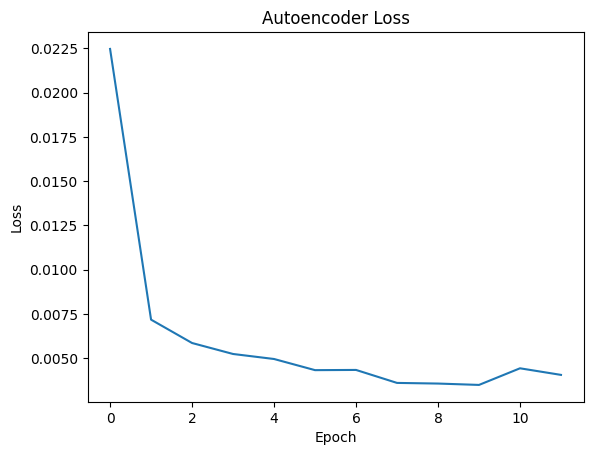

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training Loss')

The loss converges in about 8 epochs. We define convergence as no improvment over 4 epochs.

In [13]:
auto_encoder = load_model(PICKLES_PATH + "auto_encoder.h5")

2023-03-10 11:33:45.677663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 11:33:49.850194: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-03-10 11:33:49.854684: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79117 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-03-10 11:33:49.859952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/devi

In [14]:
final_cnn = auto_encoder.layers[-8].output

dense = tf.keras.layers.Flatten()(final_cnn)
dense = tf.keras.layers.Dropout(0.5)(dense)

age_dense = tf.keras.layers.Dense(1, activation='linear')(dense)
gender_dense = tf.keras.layers.Dense(1, activation='sigmoid', )(dense)


pre_trained_multi_task_model = Model(inputs=auto_encoder.input, outputs=[age_dense, gender_dense])

pre_trained_multi_task_model.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], loss_weights=[0.003, 0.997])

pre_trained_multi_task_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  2368        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [15]:
history = pre_trained_multi_task_model.fit(X_train,
        [Y_age_train, Y_gender_train],
        epochs=25,
        validation_data=(X_test, [Y_age_test, Y_gender_test]),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)],
        batch_size=64)

pre_trained_multi_task_model.save(PICKLES_PATH + "pre_trained_multi_task_model.h5")
                                    

Epoch 1/25


2023-03-10 11:34:23.672360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-10 11:34:26.046916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-10 11:34:26.047721: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f27dc00b990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-10 11:34:26.047741: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-03-10 11:34:26.047746: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-03-10 11:34:26.047750: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-03-10 11:34:26.047754: I tensorflow/compil

649/649 [==============================] - 132s 185ms/step - loss: 1.2224 - dense_loss: 243.3475 - dense_1_loss: 0.4917 - val_loss: 1.3179 - val_dense_loss: 286.1530 - val_dense_1_loss: 0.4578
Epoch 2/25
649/649 [==============================] - 113s 174ms/step - loss: 1.0826 - dense_loss: 215.6677 - dense_1_loss: 0.4329 - val_loss: 1.0826 - val_dense_loss: 217.3528 - val_dense_1_loss: 0.4268
Epoch 3/25
649/649 [==============================] - 114s 175ms/step - loss: 1.0243 - dense_loss: 202.5451 - dense_1_loss: 0.4118 - val_loss: 1.1845 - val_dense_loss: 251.1679 - val_dense_1_loss: 0.4250
Epoch 4/25
649/649 [==============================] - 116s 178ms/step - loss: 0.9669 - dense_loss: 191.3796 - dense_1_loss: 0.3856 - val_loss: 0.9930 - val_dense_loss: 201.7716 - val_dense_1_loss: 0.3795
Epoch 5/25
649/649 [==============================] - 132s 203ms/step - loss: 0.9246 - dense_loss: 183.7351 - dense_1_loss: 0.3640 - val_loss: 1.2160 - val_dense_loss: 245.7314 - val_dense_1_loss

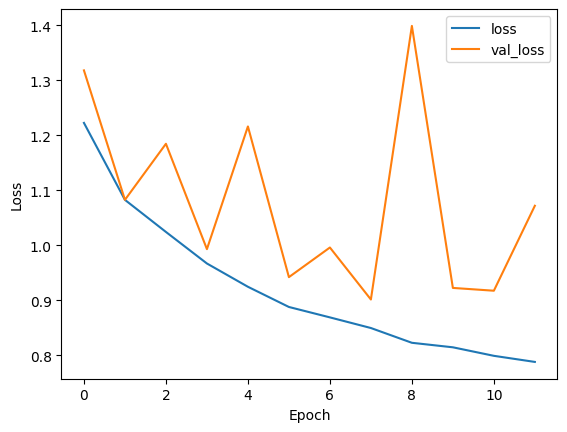

In [16]:
# plot history:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

The validation loss converges in about 7 epochs. We define convergence as no improvment over 4 epochs. The chart also shows clear signs of overfitting, which mmay indicate the SSL Strategy was ineffective. 

In [14]:
pre_trained_multi_task_model = load_model(PICKLES_PATH + "pre_trained_multi_task_model.h5")
y_hat_pretrained_multi_task_model = pre_trained_multi_task_model.predict(X_test)

2023-03-10 15:17:45.497223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 15:17:46.556738: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:bd:00.0, compute capability: 8.0
2023-03-10 15:18:02.672451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204


325/325 [==============================] - 11s 19ms/step


# Evaluation

In [5]:
with open(PICKLES_PATH + "y_hat_multi_task_model.pkl", "rb") as f:
    y_hat_multi_task_model = pickle.load(f)

with open(PICKLES_PATH + "y_hat_pretrained_multi_task_model.pickle", "rb") as f:
    y_hat_pretrained_multi_task_model = pickle.load(f)

with open(PICKLES_PATH + "y_hat_age_regression_model.pkl", "rb") as f:
    y_hat_age_regression_model = pickle.load(f)

with open(PICKLES_PATH + "y_hat_gender_classification_model.pkl", "rb") as f:
    y_hat_gender_classification_model = pickle.load(f)

## Comparing Gender Classification:

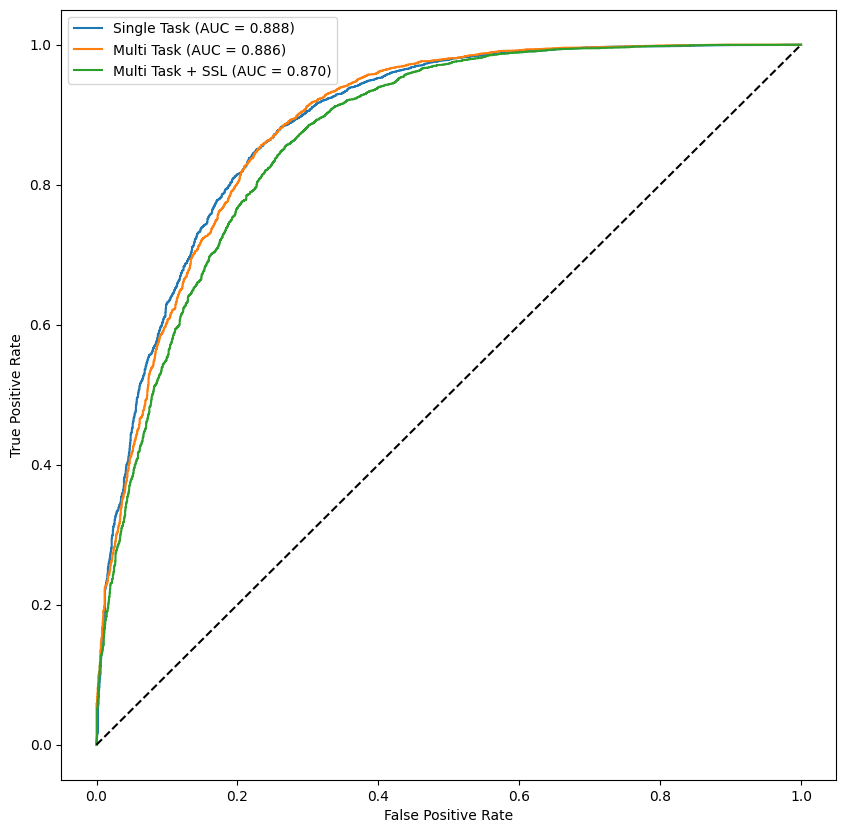

In [13]:
# plot AUC ROC curve with Y_gender_test
from sklearn.metrics import roc_curve, auc


plt.figure(figsize=(10, 10))

fpr, tpr, thresholds = roc_curve(Y_gender_test, y_hat_gender_classification_model)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Single Task (AUC = {auc_score:.3f})")

fpr, tpr, thresholds = roc_curve(Y_gender_test, y_hat_multi_task_model[1])
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Multi Task (AUC = {auc_score:.3f})")

fpr, tpr, thresholds = roc_curve(Y_gender_test, y_hat_pretrained_multi_task_model[1])
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Multi Task + SSL (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()



From the AUC-ROC curve, we can observe that all 3 models ar fairly similar with regards to ability in gender classification, but the vanilla Single and MultiTask models are fairly close to one another, and, while the single task model does have a sllightly higher AUC, neither model is dominating over the other. From the graph, this means that the single task model is silghtly better at low threshold  values for the False positive rate, but that the multitask model is better at higher threshold values, which, for gender classification, refers to correctly predcting a male or predicitng a male when the person is a female. However, both of these models are dominant over the Multitask models with SSL, which is another indication that the SSL training obejctive did not really work all that well for gender classification. 

In [18]:
# Compare accuracies between all 3 gender classification models:
from sklearn.metrics import accuracy_score

single_task_acc = accuracy_score(np.round(y_hat_gender_classification_model), Y_gender_test)
multi_task_acc = accuracy_score(np.round(y_hat_multi_task_model[1]), Y_gender_test)
multi_task_ssl_acc = accuracy_score(np.round(y_hat_pretrained_multi_task_model[1]), Y_gender_test)

In [19]:
print(f"Single Task Accuracy: {single_task_acc:.3f}")
print(f"Multi Task Accuracy: {multi_task_acc:.3f}")
print(f"Multi Task + SSL Accuracy: {multi_task_ssl_acc:.3f}")

Single Task Accuracy: 0.870
Multi Task Accuracy: 0.874
Multi Task + SSL Accuracy: 0.856


This concurs with the AUC-ROC analysis, showing that the single and multitask models are really close and the MUltitask with SSL is clearly worse

In [7]:
# mcnemar test:
from statsmodels.stats.contingency_tables import mcnemar

def perform_mcnemar_test(yhat_1, yhat_2):
    a = np.sum((yhat_1 == yhat_2) & (yhat_1 == 1))
    b = np.sum((yhat_1 != yhat_2) & (yhat_1 == 1))
    c = np.sum((yhat_1 != yhat_2) & (yhat_1 == 0))
    d = np.sum((yhat_1 == yhat_2) & (yhat_1 == 0))

    # Calculate McNemar test statistic and p-value
    result = mcnemar([[a, b], [c, d]], exact=True)
    return result.statistic, result.pvalue

In [8]:
_, pval = perform_mcnemar_test(np.round(y_hat_multi_task_model[1]), np.round(y_hat_gender_classification_model))
pval

1.1312211521375273e-26

From the low p-value of the mcnemar test  we can safely reject the null hypothesiis and conclude that the models are statistically different, which shows that there is a difference between the multitask objective and single task objective despite the CNN having the same architecture. 

In [26]:
_, pval = perform_mcnemar_test(np.round(y_hat_multi_task_model[1]), np.round(y_hat_pretrained_multi_task_model[1]))
pval

2.272363850118627e-81

The Multi-task model that was pretrained with SSL is statistically significantly different from the MultiTask model, which is interesting to note, becauase the architecture is essentially identical (with the caveat that we had to make the padding same for the inital 7x7 convolution so we could upsample for the SSL model). 

## Age Regression evaluation

We will first contruct 95% confidence intervals for the regression outputs and comnpare them to see if they are statistically different or not. 

In [15]:
def get_confidence_intervals(yhat_1, yhat_2):
    mean1 = np.mean(yhat_1)
    mean2 = np.mean(yhat_2)
    std1 = np.std(yhat_1)
    std2 = np.std(yhat_2)
    conf1 = 1.96 * std1 / np.sqrt(len(yhat_1))
    conf2 = 1.96 * std2 / np.sqrt(len(yhat_2))
    interval1 = (mean1 - conf1, mean1 + conf1)
    interval2 = (mean2 - conf2, mean2 + conf2)
    return interval1, interval2

In [13]:
get_confidence_intervals(y_hat_age_regression_model, y_hat_multi_task_model[0])

((38.54142131953066, 38.97503528447324),
 (38.038372822027725, 38.39202421166368))

From the result of these confidence intervals, we can see that the single task and multitask models are statistically differenty with a confidence level of 95% based on their confidence intervals not overlapping

In [14]:
get_confidence_intervals(y_hat_pretrained_multi_task_model[0], y_hat_multi_task_model[0])

((39.72408843485031, 40.09293579610672),
 (38.038372822027725, 38.39202421166368))

From the result of these confidence intervals, we can see that the Vanilla Multitask and SSL-Multiask models are statistically differenty with a confidence level of 95% based on their confidence intervals not overlapping

In [16]:
#get the mean absolute error for the age regression models:
from sklearn.metrics import mean_absolute_error
mae_single_task = mean_absolute_error(y_hat_age_regression_model, Y_age_test)
mae_multi_task = mean_absolute_error(y_hat_multi_task_model[0], Y_age_test)
mae_multi_task_ssl = mean_absolute_error(y_hat_pretrained_multi_task_model[0], Y_age_test)

In [17]:
print(f"Single Task MAE: {mae_single_task:.3f}")
print(f"Multi Task MAE: {mae_multi_task:.3f}")
print(f"Multi Task + SSL MAE: {mae_multi_task_ssl:.3f}")

Single Task MAE: 9.311
Multi Task MAE: 10.076
Multi Task + SSL MAE: 10.499


From this, we can see that the single task model performs the best on age regression, followed by the Vanilla MultiTask Model and the MultiTask SSL Model. This is diifferent from the gender clsasification task in that the single task model is clearly better than both MultiTask models, but shows a similar trend that the Vanilla MultiTask model once again is better than the MulitTask SSL Model. 

### Conclusion

From this analysis, we can see that the single task models were at par or better at there individual tasks than the vanilla multitask model, which was on par with the single task model on gender classification and slightly worse than the other single task model for age regression. However we did notice that obth the multitask models converged faster than the single task models, despite having to learn 2 tasks with essentially the same base architecure. 
As for the MultiTask-SSL model it was clearly outperformed by the other models, and showed signs of overfitting. This could've been because we didn't try to add noise to the images or provide validation data due to superpod issues, and that may have led to the lerned wieghts being suboptimal (fitting to noise). Additionally, the auxillary task of image reconstruction may not have been optmial for these tasks, and we also kept our arrchitecures the same across models to keep comparisions as fair as possible and didn't add anything extra to the branches in the MultiTask models beyond an output dense layer fpr each task, which may not have been optimal if the network needed more freddom to speicalze for each individual task. 